In [134]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

Suggestion: try PLA on this dataset before using the bank dataset

In [135]:
#X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
X, y = make_blobs(n_samples=80, centers=2, n_features=2)
#X, y = make_moons(n_samples=1000, noise=0.15)
y = [yy if yy == 1 else -1 for yy in y] 

In [136]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [137]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [138]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    # MPP return [pointOnBoundary(x_min), pointOnBoundary(x_max)]
    return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [139]:
def pla(training_in, training_out, weights, max_iterations=100):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        iterations+=1;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)[0]!=y):
                #iterations+=1;
                # MPP weights = weights + y*(np.concatenate((bias,x)))
                weights = (weights.T + y*(np.concatenate((bias,x)))).T
                errors+=1;
                     
        if (errors == 0):
            break
            
        # If results are not converging after maximum iterations are reached, exit
        if (iterations==max_iterations):
            break
            
    return weights, iterations

In [140]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

#### Additional Helper Functions

In [141]:
def print_dataset(X, y):
    # Plot the dataset
    
    # Assign colours based on the labels (1,-1) = (steelblue,darkred)
    colors = ['steelblue' if label == 1 else 'darkred' for label in y]
       
    # Plot Training Data
    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.title("Dataset")
    plt.scatter(X[:,0], X[:,1], color=colors) 
    
    plt.show() 

In [142]:
def plot_data_w_boundary(X, y, weights):
    # Print the data with a line representing the decision boundary
    y_bound = np.zeros([2])
    X_bound = np.zeros([2])
    
    # Get min and max X Coordinate in the Data Set    
    X_bound[0] = X[:,0].min()
    X_bound[1] = X[:,0].max()

    # Get the Y coordinates for min and max X
    y_bound[0], y_bound[1] = decision_boundary(weights, X_bound[0], X_bound[1])
    
    # Assign colours based on the labels (1,-1) = (steelblue,darkred)
    colors = ['steelblue' if label == 1 else 'darkred' for label in y]
       
    # Plot Training Data
    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.title("Dataset with Decision Boundary")
    plt.scatter(X[:,0], X[:,1], color=colors) 
    
    # Plot Decision Boundary
    plt.plot(X_bound, y_bound, linestyle='dashed', color='black')
    
    plt.show() 

In [143]:
def run_pla(X, y, verbose=1):
    # Run PLA on dataet and display results
    
    # Create and initialize weights
    weights = np.zeros([X.shape[1]+1,1])
    # Set Bias to 1
    weights[0] = 1
    
    weights, iterations = pla(X, y, weights)
    
    plot_data_w_boundary(X, y, weights)
    
    if(verbose==1):
        print("Number of Iterations:      \t",iterations)
        print("Number of Training Samples:\t",X.shape[0])
        print("Calculation Error:         \t",calc_error(X, y, weights))
    
    return weights, iterations

## Blob Dataset

Based on suggestion, using Blob datset for initial experimentation

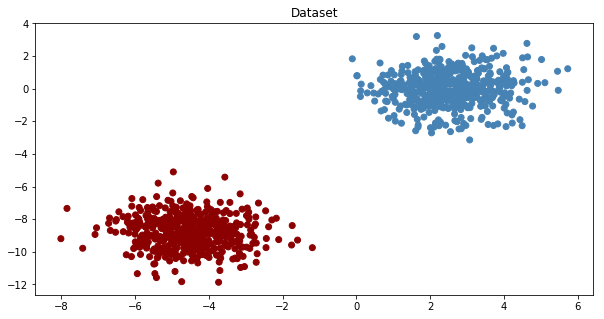

In [144]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)

y = [yy if yy == 1 else -1 for yy in y] 

print_dataset(X, y)

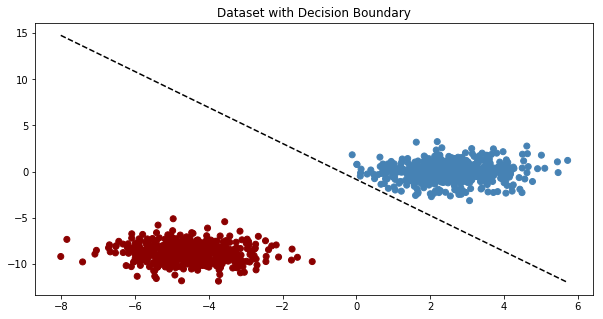

Number of Iterations:      	 2
Number of Training Samples:	 1000
Calculation Error:         	 0.0


In [145]:
run_pla(X,y);

## Moons Dataset

Moons dataset is not linearly separable.
Running similar procedure to Blobs datset to show impact to PLA when not using linearly separable data

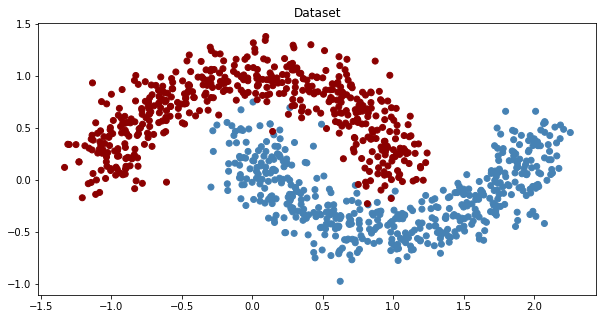

In [146]:
X, y = make_moons(n_samples=1000, noise=0.15)

y = [yy if yy == 1 else -1 for yy in y]

print_dataset(X, y)

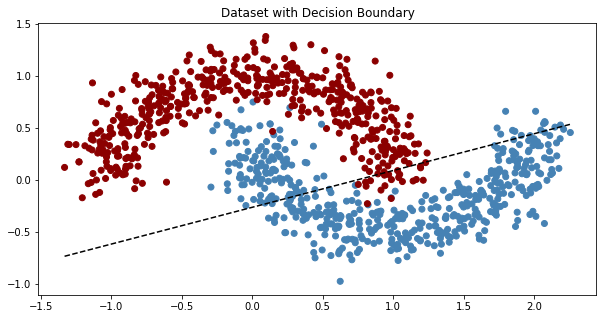

Number of Iterations:      	 100
Number of Training Samples:	 1000
Calculation Error:         	 0.154


In [147]:
run_pla(X,y);

## Task 1
* Load bank_et1.csv into a Pandas dataframe. 
* Examine the first few data rows and the last few data rows. 
* Identify an attribute that can be the target/dependable variable for 2-class classification. 
* Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below).

In [148]:
df = pd.read_csv('./bank_et1.csv')

print("Numer of Samples  in Dataset:\t",df.shape[0])
print("Numer of Features in Dataset:\t",df.shape[1])

Numer of Samples  in Dataset:	 2000
Numer of Features in Dataset:	 20


In [149]:
# Examine the first few data rows
# Print first 5 rows of the dataframe
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [150]:
# Examine the last few data rows.
# Print last 5 rows of the dataframe
df.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


#### Identify an attribute that can be the target/dependable variable for 2-class classification.

I am choosing a simple approach that is going to ignore any features with missing values and look for features that only have two unique values

The code below will print the names of any features that satisfy the following criteria:
* No missing values
* Only 2 unique values

In [151]:
for column in df:
    if((df[column].nunique()==2)and(df[column].isnull().sum()==0)):
        print(column)
        (df[column]=='no').sum()
        

default
housing
loan
subscribed


The test returns 4 different features that satisfy the condition to have only two states and to have no missing values

Inspecting these features, they all have "yes" or "no" values.

Before selecting one of these features, I want to see what the distribution of "yes" to "no" looks like in the dataset.

Intuitively, it would seem that you would want the "yes"/"no" split to be reasonably distributed such that one is not much more prevalent that the other

In [152]:
print("default   ","\tYes:\t",(df.default=='yes').sum(),"\tNo:\t",(df.default=='no').sum())
print("housing   ","\tYes:\t",(df.housing=='yes').sum(),"\tNo:\t",(df.housing=='no').sum())
print("loan      ","\tYes:\t",(df.loan=='yes').sum(),"\tNo:\t",(df.loan=='no').sum())
print("subscribed","\tYes:\t",(df.subscribed=='yes').sum(),"\tNo:\t",(df.subscribed=='no').sum())

default    	Yes:	 15 	No:	 1985
housing    	Yes:	 963 	No:	 1037
loan       	Yes:	 250 	No:	 1750
subscribed 	Yes:	 1000 	No:	 1000


"housing" and "subscribted" both have balanced, or almost balanced, distributions

Therefore, I am choosing "subscribed" as the attribute for 2-class classification

## Task 2

Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below) to perform EDA of the bank data set.

* Calculate statistics for the numerical and categorical attributes.
* Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes. Draw short conclusions (in a markdown cell).
* Generate two plots with the combined distribution of attributes and draw conclusions from them (in a markdown cell).
* Generate additional plots to identify two numerical attributes that can potentially be used for predicting the value of the dependent variable you chose in Task 1.
   - You won't find two numerical attributes that will perfectly classify a dependent variable. Pick the best you can find.

In [153]:
# Calculate statistics for the numerical attributes.

# Print statistical summary for all numerical attributes
df.describe()

,Unnamed: 0,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,577.494589,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,0.000000,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,499.750000,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,999.500000,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,1499.250000,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,1999.000000,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


Frequency Table for housing:
yes     963
no     1037
Name: housing, dtype: int64
         subscribed
housing            
no         0.768563
yes        0.210800


Text(0,0.5,'Number of Applicants')

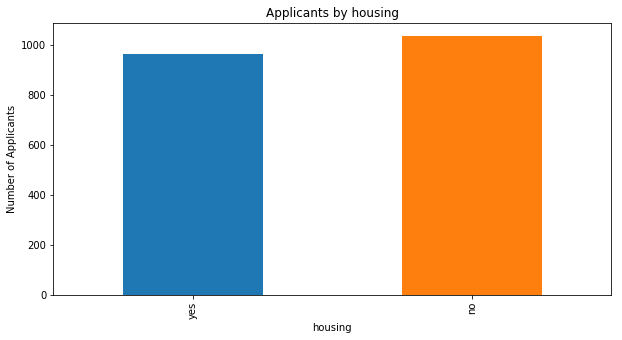

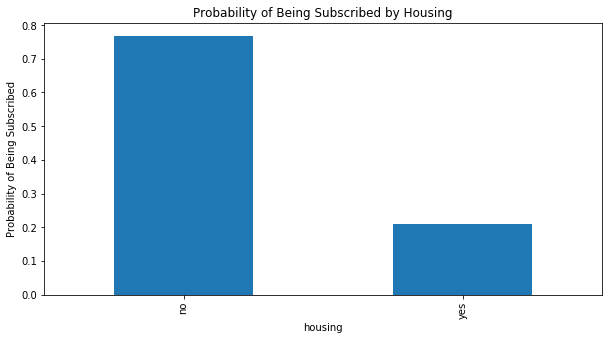

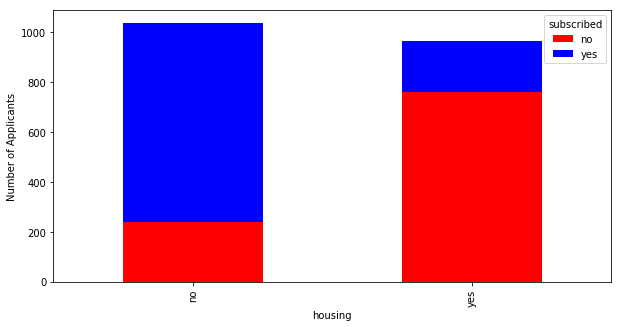

In [154]:
# Calculate statistics for the categorical attributes.

frequency_table = df['housing'].value_counts(ascending=True)
print('Frequency Table for housing:') 
print(frequency_table)

# Plot the frequency table for housing
frequency_table.plot(kind='bar')
plt.xlabel('housing')
plt.ylabel('Number of Applicants')
plt.title('Applicants by housing')


pivot_table = df.pivot_table(values='subscribed',
                       index=['housing'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean()) 

# Print pivot table
print(pivot_table)

# Plot pivot table
pivot_table.plot(kind='bar')
plt.xlabel('housing')
plt.ylabel('Probability of Being Subscribed')
plt.title('Probability of Being Subscribed by Housing')
plt.legend().set_visible(False) # we don't need the default legend


stacked_chart = pd.crosstab(df['housing'], df['subscribed'])
stacked_chart.plot(kind='bar', stacked=True, color=['red', 'blue'])
plt.ylabel('Number of Applicants')

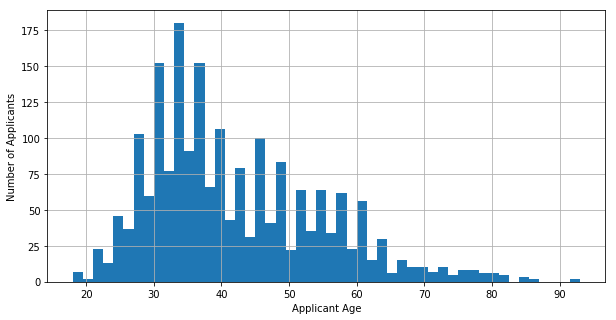

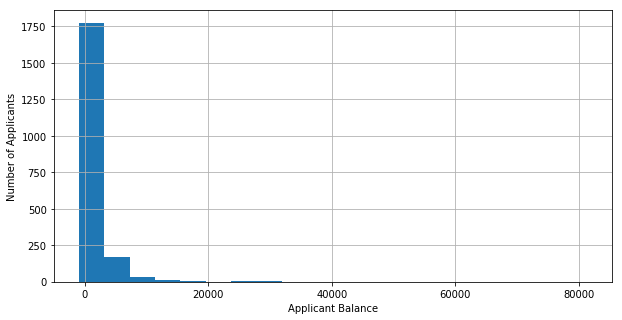

Text(0.5,0.98,'')

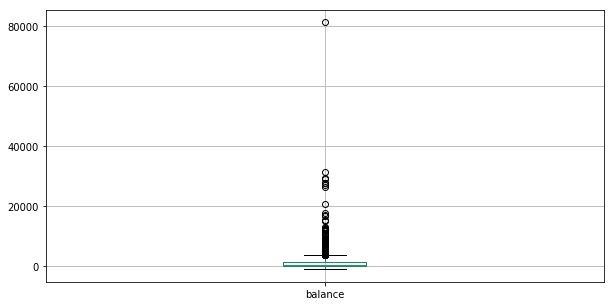

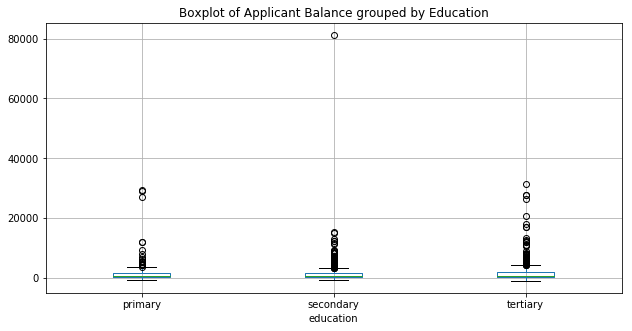

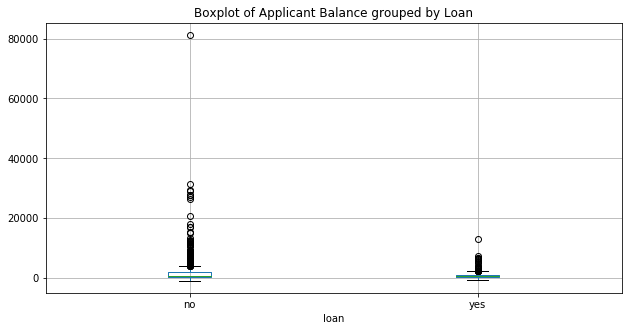

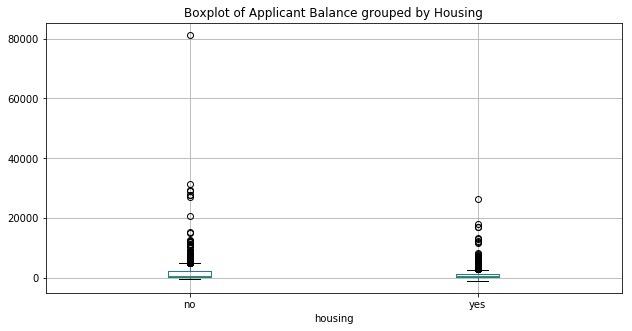

In [155]:
df['age'].hist(bins=50)
plt.xlabel('Applicant Age')
plt.ylabel('Number of Applicants')
plt.show()

df['balance'].hist(bins=20)
plt.xlabel('Applicant Balance')
plt.ylabel('Number of Applicants')
plt.show()

df.boxplot(column='balance')

# Boxplots of ApplicantIncome, grouped by the categorical attribute Education
df.boxplot(column='balance', by='education')
plt.title('Boxplot of Applicant Balance grouped by Education')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title


# Boxplots of ApplicantIncome, grouped by the categorical attribute Education
df.boxplot(column='balance', by='loan')
plt.title('Boxplot of Applicant Balance grouped by Loan')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

# Boxplots of ApplicantIncome, grouped by the categorical attribute Education
df.boxplot(column='balance', by='housing')
plt.title('Boxplot of Applicant Balance grouped by Housing')
plt.suptitle("") # get rid of the automatic 'Boxplot grouped by group_by_column_name' title

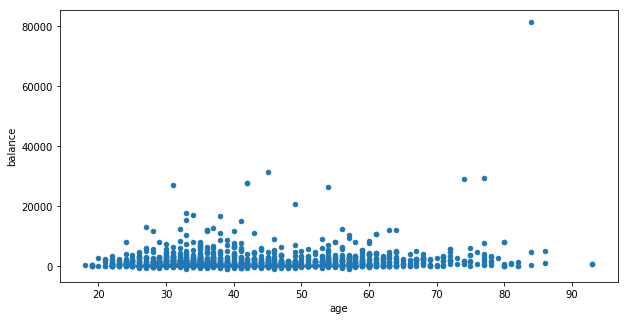

In [156]:
df.plot.scatter(x='age', y='balance')